# Aprendizado Profundo

### Autoencoders com o MNIST

- Carregamento dos pacotes necessários
- Carregamento dos dados (MNIST)
- Modelo Raso
- Modelo Profundo

<!-- Observações: 
- ativar a GPU (Menu [Runtime], opção [Change runtime type])
- Sem GPU, a execução deste caderno pode levar mais de 40 minutos. -->


## Autoencoders

<img src="https://blog.keras.io/img/ae/autoencoder_schema.jpg">

Estrutura padrão de um autoencoder:
- Camada de Codificação (Encoder)
- Camada de Decodificação (Decoder)
- Espaço Latente

Fonte (imagem e código): https://blog.keras.io/building-autoencoders-in-keras.html



## Pacotes

In [1]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
import keras.datasets as kds

import numpy as np
import matplotlib.pyplot as plt

# Bibliotecas utilizadas para projeção / redução de dimensionalidade
from sklearn.manifold import TSNE
from sklearn.decomposition import KernelPCA, PCA

## Carregamento dos dados (MNIST)

### MNIST-Fashion

Fonte: https://en.wikipedia.org/wiki/MNIST_database

No Keras: https://keras.io/api/datasets/mnist/


<img src="https://upload.wikimedia.org/wikipedia/commons/2/27/MnistExamples.png">



In [2]:
num_classes = 10
input_shape = (28, 28, 1)

# Carga dos dados (keras.datasets)
(x_train, y_train), (x_test, y_test) = kds.mnist.load_data()

# Normalização das features
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255

x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

11490434/11490434 [==============================] - 1s 0us/step
(60000, 784)
(10000, 784)


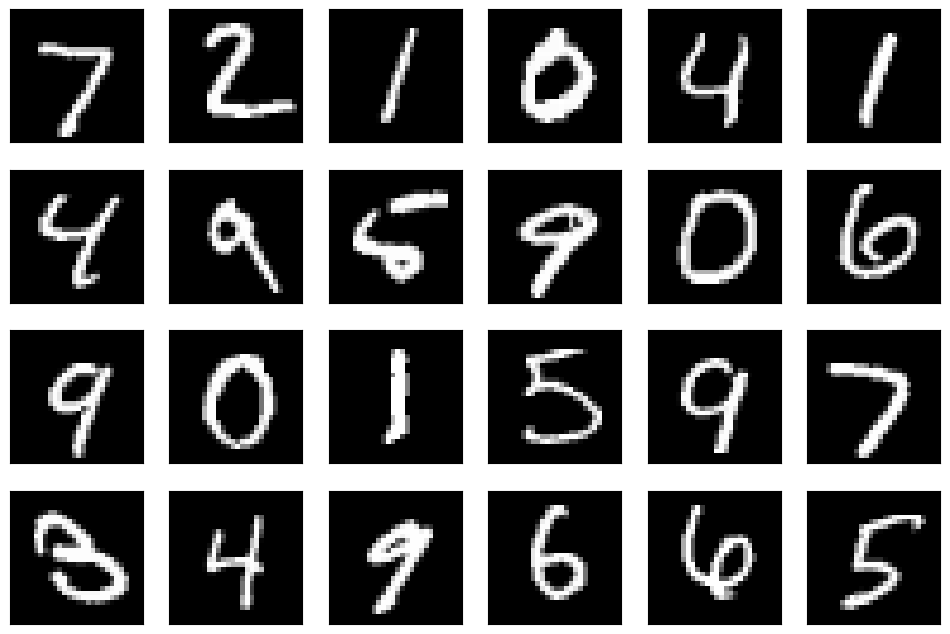

In [3]:
plt.figure(figsize=(12, 8))
for i in range(24):
    ax = plt.subplot(4, 6, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# Autoencoder 01: Autoencoder Raso

## Definição do Modelo

In [4]:
encoding_dim = 12

input_img = keras.Input(shape=(784,))
encoded = layers.Dense(encoding_dim, activation='relu')(input_img)
decoded = layers.Dense(784, activation='sigmoid')(encoded)

autoencoder01 = keras.Model(input_img, decoded)
autoencoder01.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense (Dense)               (None, 12)                9420      
                                                                 
 dense_1 (Dense)             (None, 784)               10192     
                                                                 
Total params: 19,612
Trainable params: 19,612
Non-trainable params: 0
_________________________________________________________________


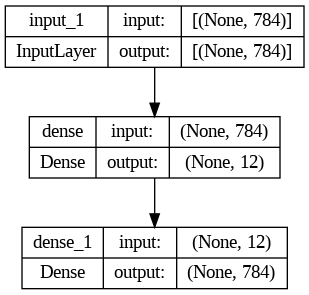

In [5]:
tf.keras.utils.plot_model(autoencoder01, show_shapes=True)

## Criação dos modelos Encoder e Decoder

In [6]:
encoder01 = keras.Model(input_img, encoded)

encoded_input = keras.Input(shape=(encoding_dim,))
decoder_layer = autoencoder01.layers[-1]
decoder01 = keras.Model(encoded_input, decoder_layer(encoded_input))

## Treinamento do Autoencoder 01

In [7]:
autoencoder01.compile(optimizer='adam', loss='binary_crossentropy')
history = autoencoder01.fit(x_train, x_train,
                            epochs=50,
                            batch_size=256,
                            shuffle=True,
                            validation_data=(x_test, x_test),
                            verbose=1) # usar 1 ou 2 para observar a evolucão por época

Epoch 1/50
235/235 [==============================] - 7s 6ms/step - loss: 0.3205 - val_loss: 0.2396
Epoch 2/50
235/235 [==============================] - 1s 5ms/step - loss: 0.2122 - val_loss: 0.1907
Epoch 3/50
235/235 [==============================] - 1s 4ms/step - loss: 0.1832 - val_loss: 0.1744
Epoch 4/50
235/235 [==============================] - 1s 4ms/step - loss: 0.1704 - val_loss: 0.1651
Epoch 5/50
235/235 [==============================] - 1s 4ms/step - loss: 0.1632 - val_loss: 0.1600
Epoch 6/50
235/235 [==============================] - 1s 4ms/step - loss: 0.1595 - val_loss: 0.1573
Epoch 7/50
235/235 [==============================] - 1s 4ms/step - loss: 0.1572 - val_loss: 0.1554
Epoch 8/50
235/235 [==============================] - 1s 4ms/step - loss: 0.1556 - val_loss: 0.1539
Epoch 9/50
235/235 [==============================] - 1s 4ms/step - loss: 0.1542 - val_loss: 0.1525
Epoch 10/50
235/235 [==============================] - 1s 4ms/step - loss: 0.1529 - val_loss: 0.1513

## Avaliação

313/313 [==============================] - 1s 1ms/step


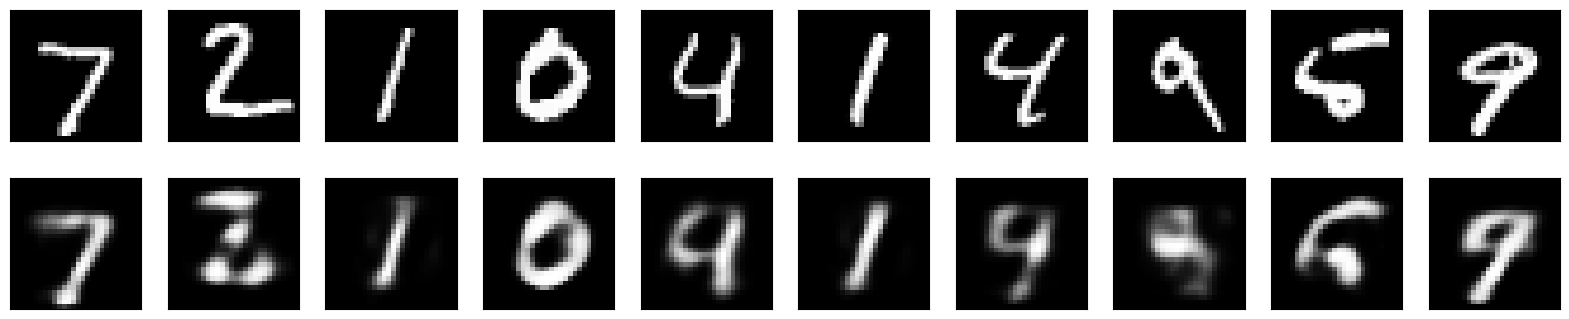

In [8]:
decoded_imgs01 = autoencoder01.predict(x_test)

n = 10  # Imagens visualizadas
plt.figure(figsize=(20, 4))
for i in range(n):
    # Original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Reconstrução
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs01[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

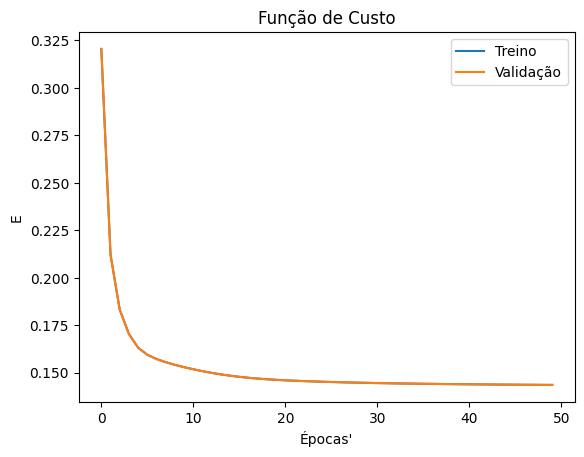

In [9]:
plt.figure()
plt.plot(history.history["loss"], label = "Treino")
plt.plot(history.history["loss"], label = "Validação")
plt.title("Função de Custo")
plt.ylabel("E")
plt.xlabel("Épocas'")
plt.legend()
plt.show()

### Projeção com PCA

https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html

40/40 [==============================] - 0s 2ms/step


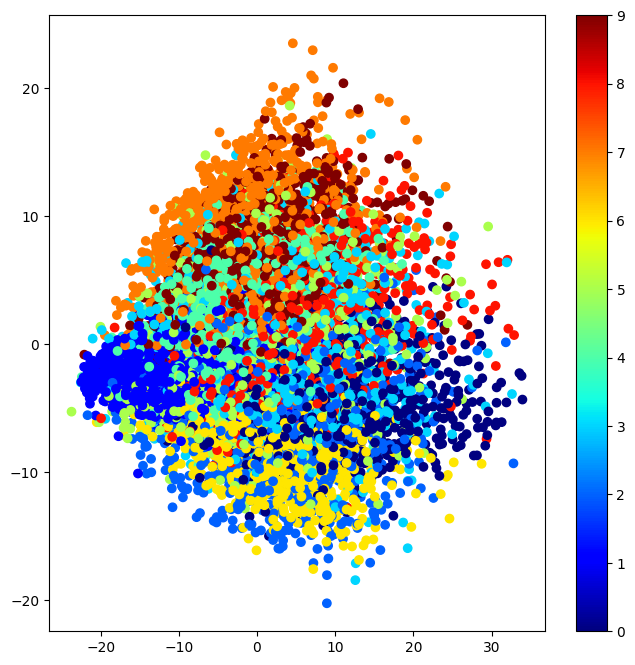

In [10]:
x_test_encoded = encoder01.predict(x_test, batch_size=256)

x_emb = PCA(n_components=2).fit_transform(x_test_encoded)

plt.figure(figsize=(8, 8))
plt.scatter(x_emb[:, 0], x_emb[:, 1], c=y_test, cmap=plt.cm.jet)
plt.colorbar()
plt.show()

### Projeção com t-SNE

https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html

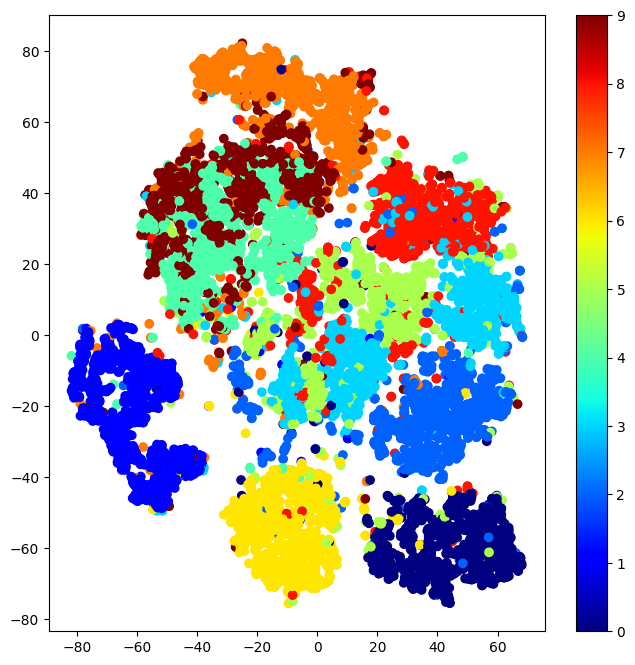

In [11]:
x_emb = TSNE(n_components=2).fit_transform(x_test_encoded)

plt.figure(figsize=(8, 8))
plt.scatter(x_emb[:, 0], x_emb[:, 1], c=y_test, cmap=plt.cm.jet)
plt.colorbar()
plt.show()

# Autoencoder 02: Autoencoder profundo


## Definição do Modelo

In [12]:
encoding_dim = 12

input_img = keras.Input(shape=(784,))
encoded = layers.Dense(128, activation='relu')(input_img)
encoded = layers.Dense(64, activation='relu')(encoded)
encoded = layers.Dense(encoding_dim, activation='relu')(encoded)
decoded = layers.Dense(64, activation='relu')(encoded)
decoded = layers.Dense(128, activation='relu')(decoded)
decoded = layers.Dense(784, activation='sigmoid')(decoded)

autoencoder02 = keras.Model(input_img, decoded)
autoencoder02.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense_2 (Dense)             (None, 128)               100480    
                                                                 
 dense_3 (Dense)             (None, 64)                8256      
                                                                 
 dense_4 (Dense)             (None, 12)                780       
                                                                 
 dense_5 (Dense)             (None, 64)                832       
                                                                 
 dense_6 (Dense)             (None, 128)               8320      
                                                                 
 dense_7 (Dense)             (None, 784)               1011

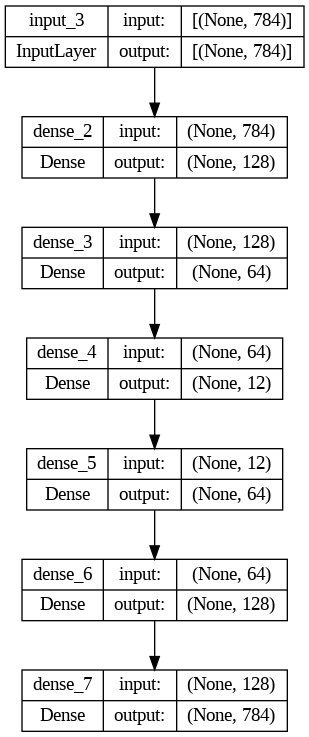

In [13]:
tf.keras.utils.plot_model(autoencoder02, show_shapes=True)

## Criação dos modelos Encoder e Decoder

In [14]:
encoder02 = keras.Model(input_img, encoded)

encoded_input = keras.Input(shape=(encoding_dim,))
decoder_layer = autoencoder02.layers[-3] # número de camada da saída até a codificação latente
decoder02 = keras.Model(encoded_input, decoder_layer(encoded_input))

## Treinamento do Autoencoder

In [15]:
autoencoder02.compile(optimizer='adam', loss='binary_crossentropy')

history = autoencoder02.fit(x_train, x_train,
                            epochs=100,
                            batch_size=256,
                            shuffle=True,
                            validation_data=(x_test, x_test),                  
                            verbose=1) # usar 1 ou 2 para observar a evolucão por época

Epoch 1/100
235/235 [==============================] - 3s 5ms/step - loss: 0.2654 - val_loss: 0.1957
Epoch 2/100
235/235 [==============================] - 1s 5ms/step - loss: 0.1730 - val_loss: 0.1535
Epoch 3/100
235/235 [==============================] - 2s 6ms/step - loss: 0.1480 - val_loss: 0.1411
Epoch 4/100
235/235 [==============================] - 1s 6ms/step - loss: 0.1390 - val_loss: 0.1343
Epoch 5/100
235/235 [==============================] - 1s 5ms/step - loss: 0.1327 - val_loss: 0.1284
Epoch 6/100
235/235 [==============================] - 1s 5ms/step - loss: 0.1285 - val_loss: 0.1259
Epoch 7/100
235/235 [==============================] - 1s 4ms/step - loss: 0.1259 - val_loss: 0.1232
Epoch 8/100
235/235 [==============================] - 1s 5ms/step - loss: 0.1238 - val_loss: 0.1215
Epoch 9/100
235/235 [==============================] - 1s 5ms/step - loss: 0.1222 - val_loss: 0.1204
Epoch 10/100
235/235 [==============================] - 1s 5ms/step - loss: 0.1207 - val_lo

## Avaliação

313/313 [==============================] - 1s 2ms/step


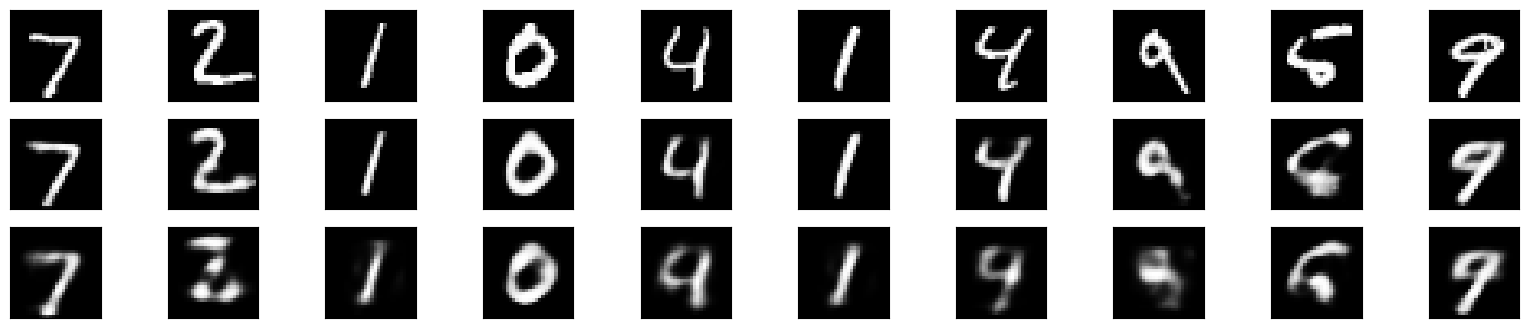

In [16]:
decoded_imgs02 = autoencoder02.predict(x_test)

n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(decoded_imgs02[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction (raso)
    ax = plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(decoded_imgs01[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

### Projeção PCA

40/40 [==============================] - 0s 2ms/step


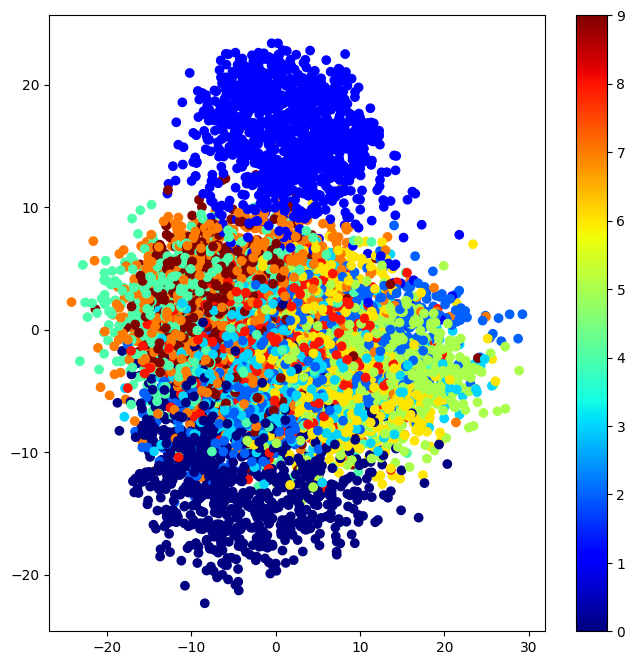

In [17]:
x_test_encoded = encoder02.predict(x_test, batch_size=256)

x_emb = PCA(n_components=2).fit_transform(x_test_encoded)

plt.figure(figsize=(8, 8))
plt.scatter(x_emb[:, 0], x_emb[:, 1], c=y_test, cmap=plt.cm.jet)
plt.colorbar()
plt.show()

### Projeção t-SNE

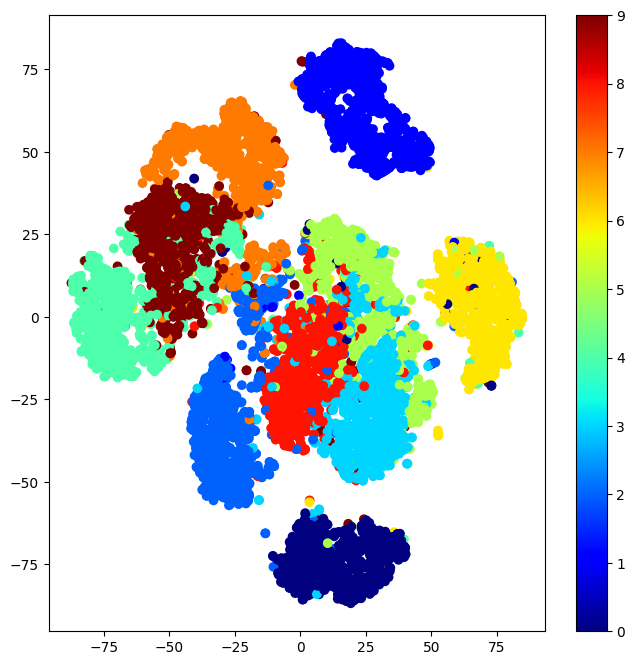

In [18]:
x_emb = TSNE(n_components=2).fit_transform(x_test_encoded)

plt.figure(figsize=(8, 8))
plt.scatter(x_emb[:, 0], x_emb[:, 1], c=y_test, cmap=plt.cm.jet)
plt.colorbar()
plt.show()

# Observações sobre o Espaço Latente


- A dimensão do espaço latente não necessariamente precisa ser menor que a dimensão original
- Podemos usar autoencoders esparsos para ampliar a dimensionalidade de representação do problema
- Os autoencoders esparsos demandam algum tipo de regularização para evitar o aprendizado da solução trivial

# Exercício de Apoio

## Utilizando o código acima, substitua as camadas densas por camadas convolucionais.

### Siga a mesma abordagem utilizada:

1. Um modelo convolucional raso (apenas um nível convolucional no encoder e um nível no decoder)
2. Um modelo convolucional profundo (pelo menos 3 níveis de convolução no encoder e no decoder)
- Varie o número de filtros em cada nível convolucional

### Observações:
- Para as camadas convolucionais do encoder, utilizar: layers.Conv2D
- Para o decoder: layers.UpSampling2D
- Ver o exemplo disponível em: https://blog.keras.io/building-autoencoders-in-keras.html

Por fim, reporte os resultados no forum de discussão da semana




